In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [112]:
from analysis.basic_inspection import DataInspector, DataTypesInspection, SummaryStatistics
from analysis.univariate_analysis import UnivariateAnalyzer, NumericalUnivariate, CategoricalUnivariate
from analysis.bivariate_analysis import BivariateAnalysisStrategy, NumericalVsCategoricalAnalysis, NumericalVsNumerical, BivariateAnalyzer

In [3]:
df_original = pd.read_csv("../data/interm/invalid_rows_remove.csv")
df = df_original.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11083 entries, 0 to 11082
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vote_average  11083 non-null  float64
 1   vote_count    11083 non-null  int64  
 2   revenue       11083 non-null  int64  
 3   runtime       11083 non-null  int64  
 4   budget        11083 non-null  int64  
 5   popularity    11083 non-null  float64
 6   genres        11083 non-null  object 
dtypes: float64(2), int64(4), object(1)
memory usage: 606.2+ KB


## Vote average

In [5]:
inspector = DataInspector(DataTypesInspection())

In [6]:
univariate_analyzer = UnivariateAnalyzer(NumericalUnivariate())

2025-08-13 08:37:11,436 - INFO - Image vote_average_dist saved in ../artifacts/images


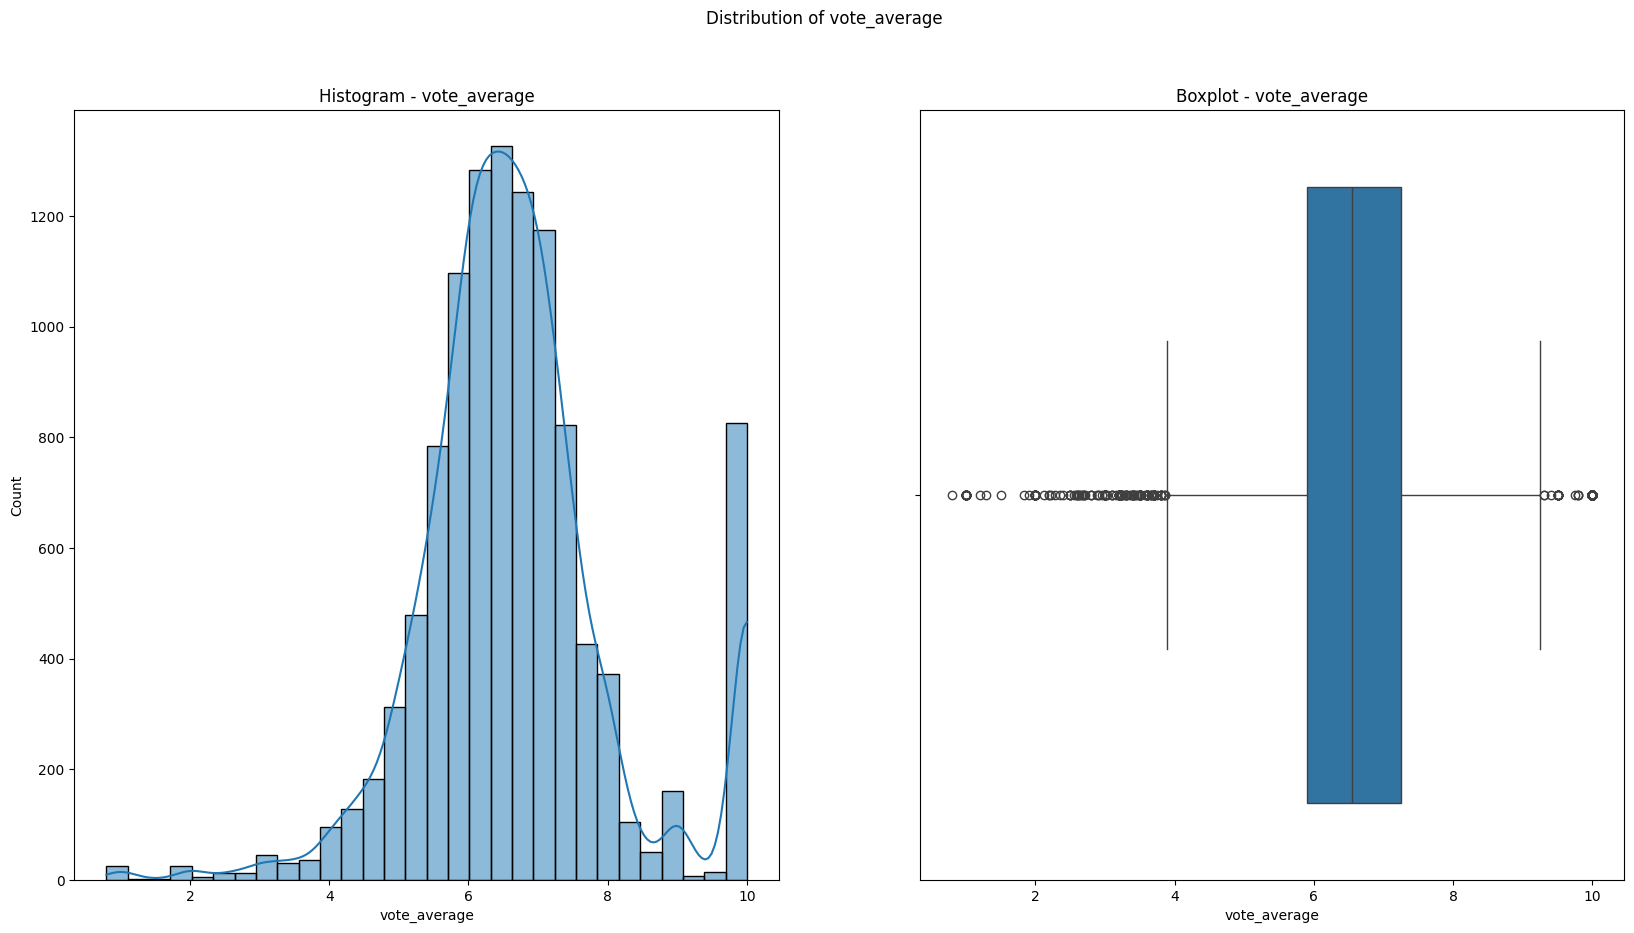

count    11083.000000
mean         6.675401
std          1.395366
min          0.800000
25%          5.900500
50%          6.554000
75%          7.244000
max         10.000000
Name: vote_average, dtype: float64


In [7]:
univariate_analyzer.execute_analysis(df, 'vote_average', box=True, save=True, filename='vote_average_dist')

#### Insights

There is a normal distribution. The mean is 6.675401 with a standar deviation of 1.395366. There is a lot of outliers too.

## Vote Count

2025-08-13 08:37:12,181 - INFO - Image vote_count_log saved in ../artifacts/images


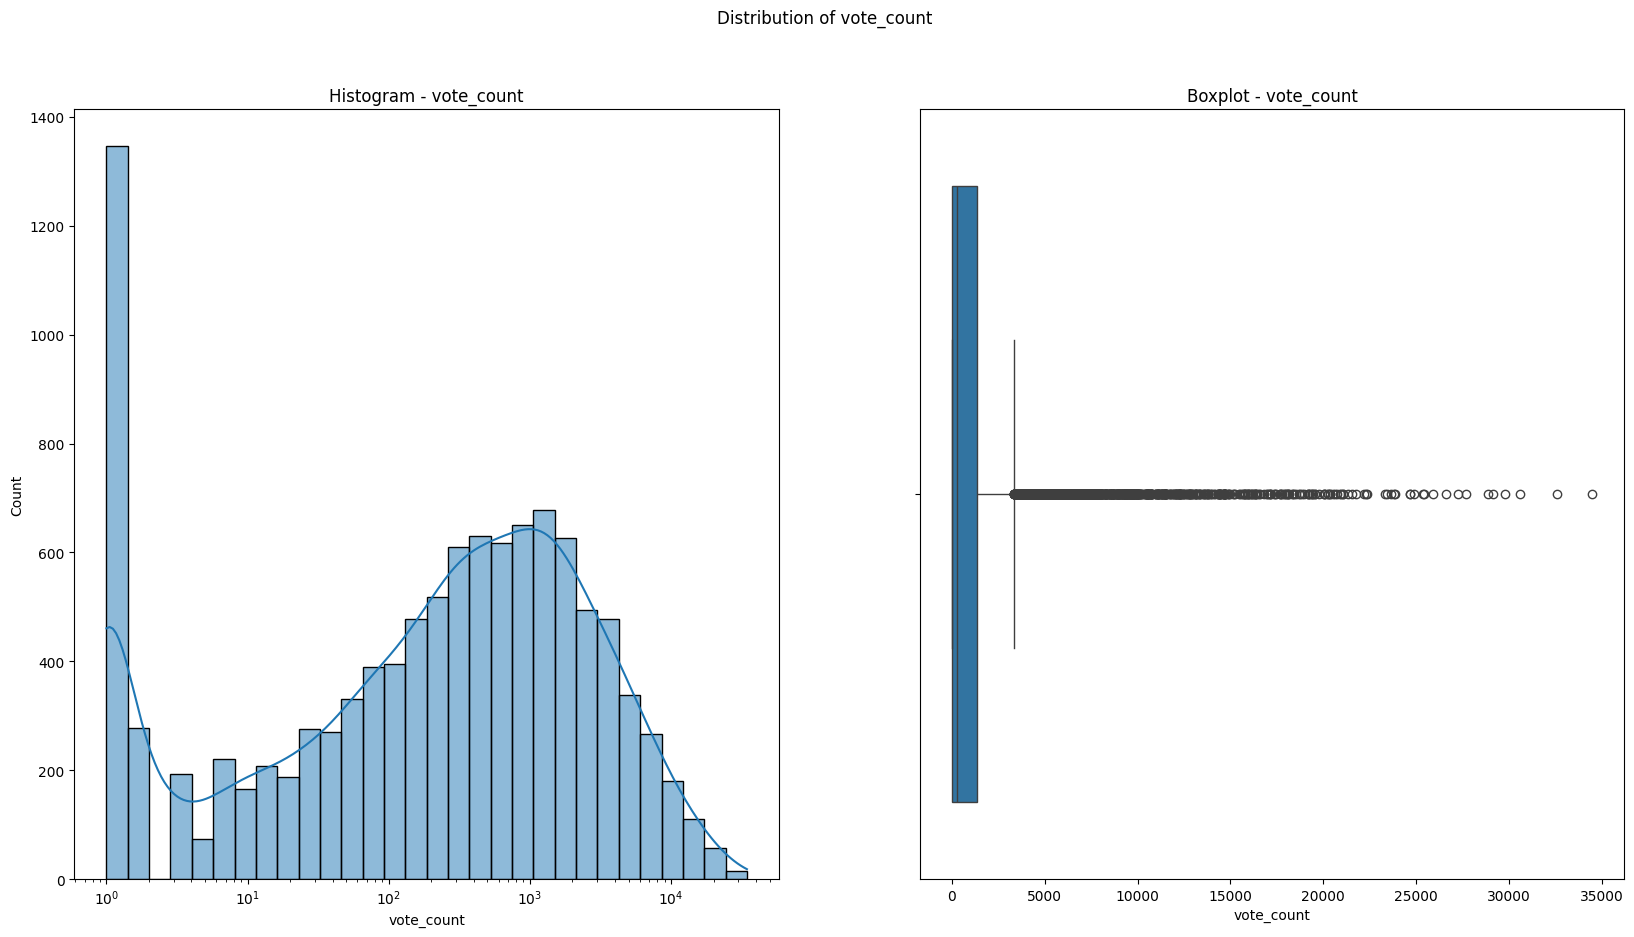

count    11083.000000
mean      1379.962194
std       2865.529875
min          1.000000
25%         26.000000
50%        295.000000
75%       1356.000000
max      34495.000000
Name: vote_count, dtype: float64


In [8]:
univariate_analyzer.execute_analysis(df, "vote_count", box=True, log=True, save=True, filename='vote_count_log')

### Insight 

Many movies have few votes, so it may be worth removing them from the dataset. The first experiment will be run without any filtering, and the second will exclude movies with low vote counts.  

## Revenue

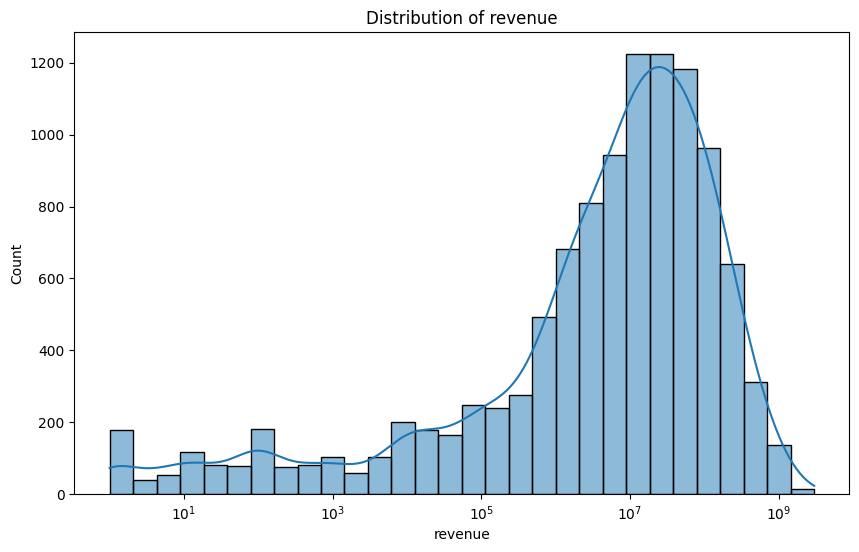

count    1.108300e+04
mean     6.183545e+07
std      1.553194e+08
min      1.000000e+00
25%      8.371660e+05
50%      9.995168e+06
75%      5.009181e+07
max      3.000000e+09
Name: revenue, dtype: float64


In [9]:
univariate_analyzer.execute_analysis(df, 'revenue', log=True)

The distribution is heavily right-skewed, suggesting that most movies generate low to moderate revenue, with only a few high-grossing outliers.

## Budget

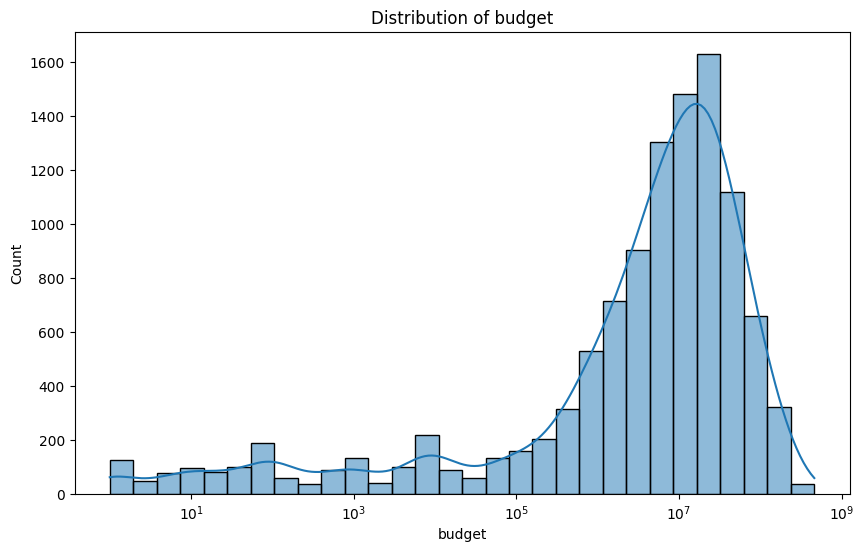

count    1.108300e+04
mean     2.162855e+07
std      3.711750e+07
min      1.000000e+00
25%      1.000000e+06
50%      7.400000e+06
75%      2.500000e+07
max      4.600000e+08
Name: budget, dtype: float64


In [10]:
univariate_analyzer.execute_analysis(df, 'budget', log=True)

The distribution is heavily right-skewed, suggesting that most movies have low to moderate budget, with only a few high-grossing outliers.

## Runtime

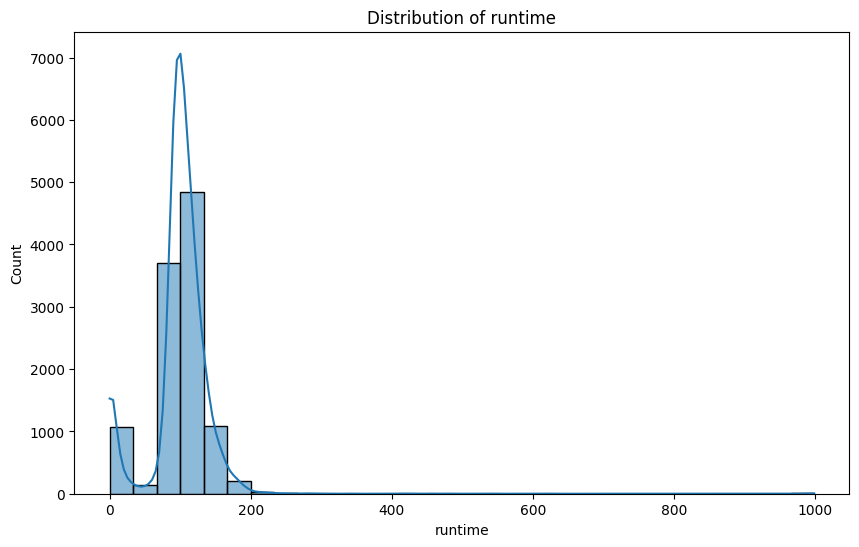

count    11083.000000
mean        99.646756
std         42.547834
min          0.000000
25%         90.000000
50%        102.000000
75%        118.000000
max        999.000000
Name: runtime, dtype: float64


In [13]:
univariate_analyzer.execute_analysis(df, 'runtime')

Most movies have a runtime of around 102 minutes. There are some movies with a runtime of 0 minutes, which does not make sense, and others with unusually long runtimes. This suggests we may need to remove these outliers, filter them using the IQR method, or apply a robust scaler.

In [32]:
df = df[df['runtime'] > 0] #Only we need the movies with runtime > 0

In [34]:
q_low = df['runtime'].quantile(0.01)
q_high = df['runtime'].quantile(0.99)

df['runtime'] = np.clip(df['runtime'], q_low, q_high)

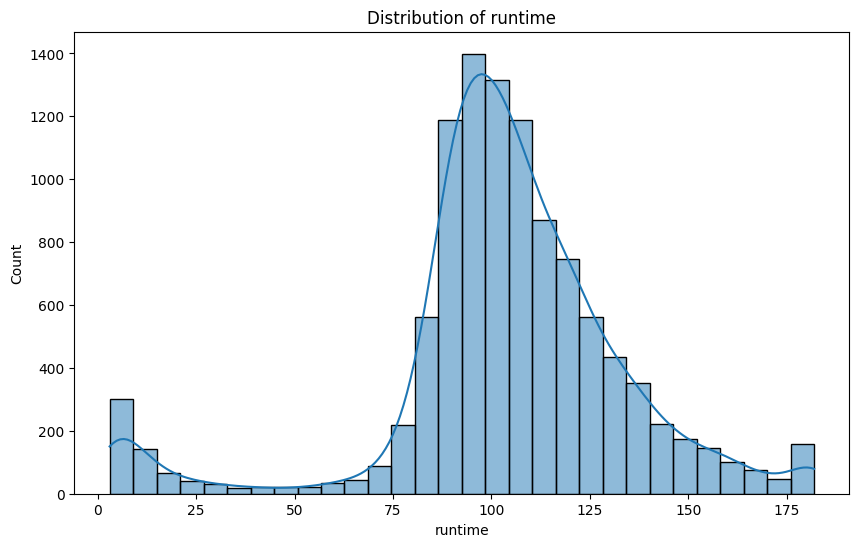

count    10600.000000
mean       103.517358
std         31.543477
min          3.000000
25%         92.000000
50%        103.000000
75%        119.000000
max        182.000000
Name: runtime, dtype: float64


In [35]:
univariate_analyzer.execute_analysis(df, 'runtime')

We applied winsorization because the outliers are genuine data points, and we want to retain them. The resulting distribution is left-skewed, and the mean and median are close to each other.

/home/shura/projects/programming/datascience/talento-tech/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


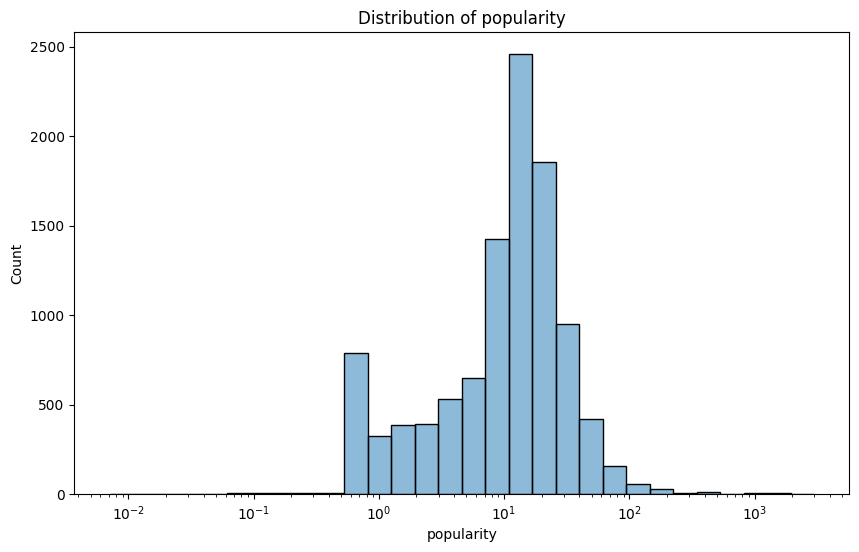

count    10600.000000
mean        18.315983
std         60.022164
min          0.000000
25%          4.988250
50%         12.463500
75%         19.889250
max       2994.357000
Name: popularity, dtype: float64


In [42]:
univariate_analyzer.execute_analysis(df, 'popularity', log=True)

Popularity is positively skewed and contains many extreme outliers. For this reason, it is advisable to apply a logarithmic transformation.

## Genres

In [110]:
df["genres_list"] = df['genres'].fillna("ninguno").str.split(", ")
genre_freq = df[["genres_list"]]["genres_list"].explode().value_counts(normalize=True).to_dict()
df['genres_freq_list'] = df["genres_list"].apply(lambda lst: [genre_freq[g] for g in lst])
df['genres_freq_mean'] = df['genres_freq_list'].apply(lambda freqs: np.mean(freqs) if freqs else 0)

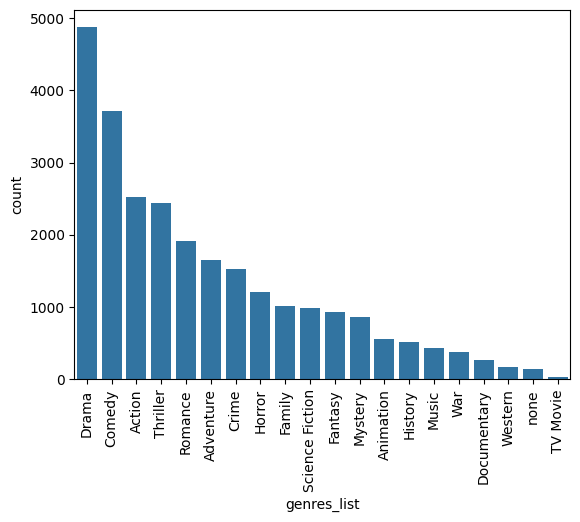

In [97]:
sns.barplot(data=genres_count)
plt.xticks(rotation=90)
plt.show()

Most movies are dramas. We can’t use one-hot encoding because many of the resulting vectors would be sparse.

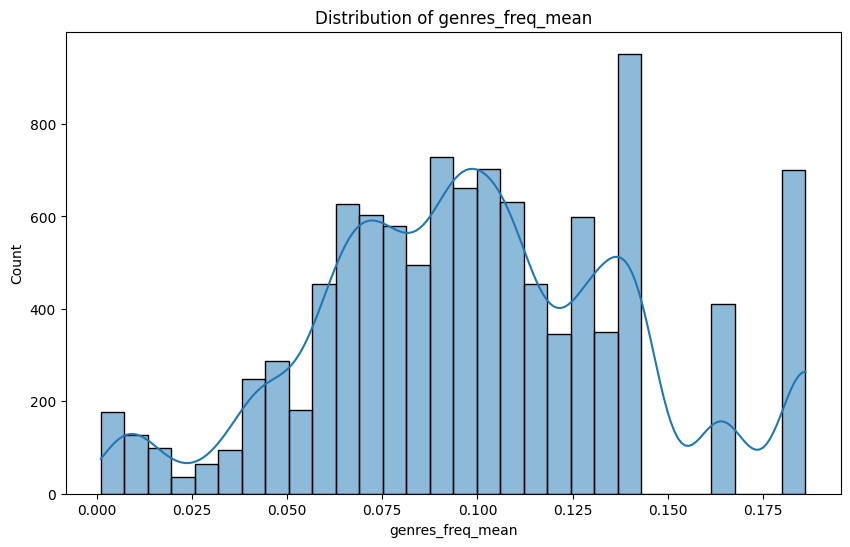

count    10600.000000
mean         0.100056
std          0.041761
min          0.001109
25%          0.071041
50%          0.098341
75%          0.129655
max          0.186128
Name: genres_freq_mean, dtype: float64


In [105]:
univariate_analyzer.execute_analysis(df, 'genres_freq_mean')

It looks like a multimodal distribution, which indicates different genre combinations.

In [106]:
df

,vote_average,vote_count,revenue,runtime,budget,popularity,genres,runtime_test,genres_list,freq_list,genres_freq_mean
0,8.364,34495,825532764,148,160000000,83.952,"Action, Science Fiction, Adventure",148,"[Action, Science Fiction, Adventure]","[0.09665825495144147, 0.03789095358262599, 0.0...",0.065981
1,8.417,32571,701729206,169,165000000,140.241,"Adventure, Drama, Science Fiction",169,"[Adventure, Drama, Science Fiction]","[0.06339374474267799, 0.18612831689225356, 0.0...",0.095804
2,8.512,30619,1004558444,152,185000000,130.643,"Drama, Action, Crime, Thriller",152,"[Drama, Action, Crime, Thriller]","[0.18612831689225356, 0.09665825495144147, 0.0...",0.108655
3,7.573,29815,2923706026,162,237000000,79.932,"Action, Adventure, Fantasy, Science Fiction",162,"[Action, Adventure, Fantasy, Science Fiction]","[0.09665825495144147, 0.06339374474267799, 0.0...",0.058414
4,7.710,29166,1518815515,143,220000000,98.082,"Science Fiction, Action, Adventure",143,"[Science Fiction, Action, Adventure]","[0.03789095358262599, 0.09665825495144147, 0.0...",0.065981
...,...,...,...,...,...,...,...,...,...,...,...
11072,10.000,1,1,5,1,0.400,Drama,5,[Drama],[0.18612831689225356],0.186128
11074,10.000,1,2820,65,28209,0.600,Drama,65,[Drama],[0.18612831689225356],0.186128
11078,1.000,1,100,11,2000,1.097,Comedy,11,[Comedy],[0.14185210675231322],0.141852
11080,10.000,1,200,34,200,0.600,Documentary,34,[Documentary],[0.010132293339450944],0.010132


# Bivariate Analysis

In [113]:
bivariate_analyzer = BivariateAnalyzer(NumericalVsNumerical())

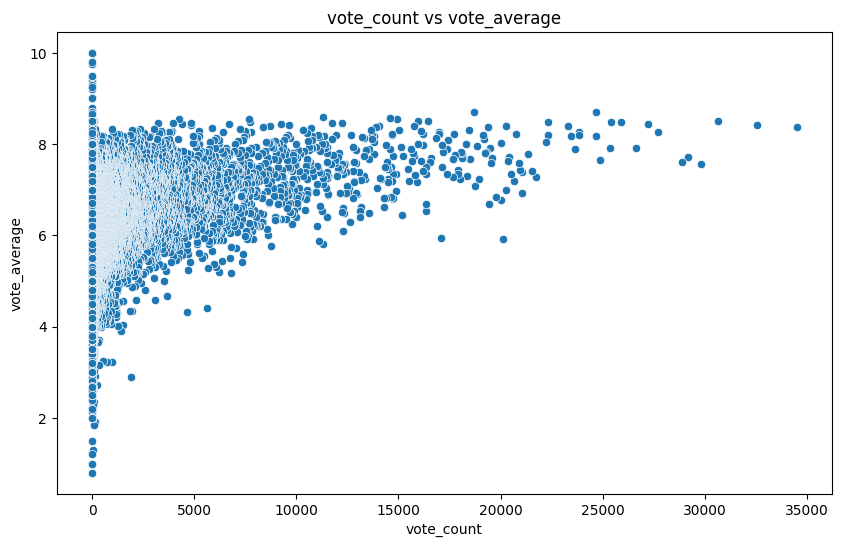

0.15319010186054866


In [116]:
bivariate_analyzer.execute_analysis(df, 'vote_count', 'vote_average', corr=True)